## Kernel visualization
Troubleshooting RSMAS kernel implementation

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, re
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [3]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
kern_dir ='feedbacks_soden/mod_by_me/kernels/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(kern_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [4]:
os.listdir(kern_dir)

['TOA_JSHAW', 'TOA_LISE', 'SFC_GFDL', 'TOA_GFDL']

In [5]:
os.listdir("%s%s" % (kern_dir,'TOA_LISE'))

['swclr_q_gfdl_std.nc',
 'lwclr_q_gfdl_std.nc',
 'swclr_a_gfdl_std.nc',
 'sw_q_gfdl_std.nc',
 'sw_a_gfdl_std.nc',
 'lw_t_gfdl_std.nc',
 'lwclr_t_gfdl_std.nc',
 'lw_q_gfdl_std.nc']

In [6]:
lise_kern = xr.open_dataarray("%s%s/%s" % (kern_dir,'TOA_LISE','lwclr_q_gfdl_std.nc'),decode_times=False)

In [7]:
RSMAS_kern = xr.open_dataarray("%s%s/%s" % (kern_dir,'TOA_GFDL','lwclr_q_gfdl_toa.nc'),decode_times=False)

In [8]:
lise_kern.shape

(12, 18, 90, 144)

In [9]:
RSMAS_kern.shape

(12, 17, 90, 144)

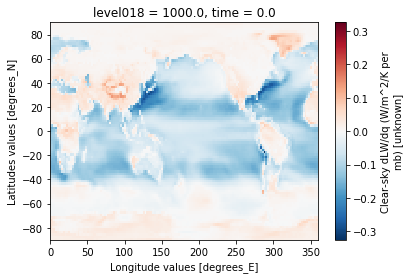

In [18]:
lise_kern[0,4,:,:].plot()

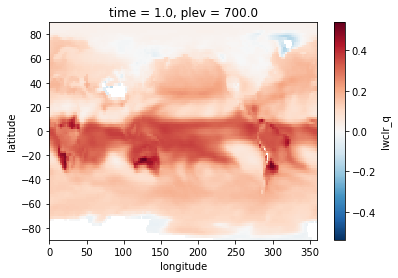

In [19]:
RSMAS_kern[0,3,:,:].plot()

In [97]:
os.listdir("%s%s" % (kern_dir,'TOA_GFDL'))

['sw_a_gfdl_toa.nc',
 'lwclr_t_gfdl_toa.nc',
 'new_kern.nc',
 'lw_q_gfdl_toa.nc',
 'lwclr_q_gfdl_toa.nc',
 'sw_q_gfdl_toa.nc',
 'lw_t_gfdl_toa.nc',
 'swclr_q_gfdl_toa.nc',
 'swclr_a_gfdl_toa.nc',
 'TOA_GFDL_Kerns.nc']

In [119]:
for _file in os.listdir("%s%s" % (kern_dir,'TOA_GFDL')):
    try:
        _da = xr.open_dataarray("%s%s/%s" % (kern_dir,'TOA_GFDL',_file),decode_times=False)
        # Pick out files with a vertical dimension, tested
        if "plev" in _da.dims:
            print("Found 'plev' in %s" % _file)
            _new_lev = xr.zeros_like(_da.isel(plev=0))
            _new_lev['plev'] = float(1050)
            _new_kern = xr.concat([_new_lev,_da],dim='plev')
            _new_kern = _new_kern.transpose("time", "plev", "latitude",'longitude')
            _new_kern.to_netcdf("%s%s/%s" % (kern_dir,'TOA_JSHAW',_file))            
        else:
            print("No 'plev' in %s" % _file)
            _da.to_netcdf("%s%s/%s" % (kern_dir,'TOA_JSHAW',_file))   
    except: # catch the DataArray
        print("Could not load: ", _file)

No 'plev' in sw_a_gfdl_toa.nc
Found 'plev' in lwclr_t_gfdl_toa.nc
Found 'plev' in new_kern.nc
Found 'plev' in lw_q_gfdl_toa.nc
Found 'plev' in lwclr_q_gfdl_toa.nc
Found 'plev' in sw_q_gfdl_toa.nc
Found 'plev' in lw_t_gfdl_toa.nc
Found 'plev' in swclr_q_gfdl_toa.nc
No 'plev' in swclr_a_gfdl_toa.nc
Could not load:  TOA_GFDL_Kerns.nc


In [105]:
_da.dims

('time', 'latitude', 'longitude')

In [123]:
lise_kern['time']

<xarray.DataArray 'time' (time: 12)>
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
Attributes:
    standard_name:  time
    long_name:      Time coordinate values
    units:          months since 1987-01-01 00:00:00
    calendar:       standard

In [122]:
RSMAS_kern['time']

<xarray.DataArray 'time' (time: 12)>
array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
Coordinates:
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

In [30]:
RSMAS_kern.plev

<xarray.DataArray 'plev' (plev: 17)>
array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,  200.,
        150.,  100.,   70.,   50.,   30.,   20.,   10.])
Coordinates:
  * plev     (plev) float64 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
Attributes:
    axis:     Z

In [108]:
RSMAS_kern[:,0,:,:].shape

(12, 90, 144)

In [116]:
lise_kern.isel(level018=0).shape

(12, 90, 144)

In [32]:
new_lev = xr.zeros_like(RSMAS_kern[:,0,:,:])

In [45]:
new_lev['plev'] = float(1050)

In [63]:
new_lev;

In [56]:
new_kern = xr.concat([new_lev,RSMAS_kern],dim='plev')
new_kern = new_kern.transpose("time", "plev", "latitude",'longitude')

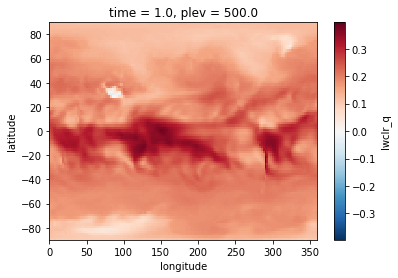

In [94]:
new_kern[0,6,:,:].plot()

In [87]:
new_kern = new_kern.fillna(-999)

In [71]:
new_kern.to_netcdf("%s%s/%s" % (kern_dir,'TOA_JSHAW','lwclr_q_gfdl_toa.nc'))

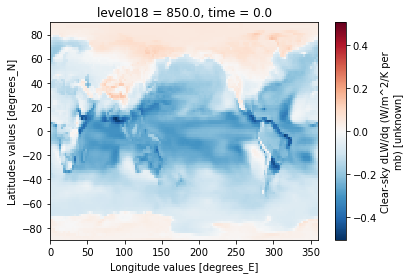

In [70]:
lise_kern[0,3,:,:].plot()

In [40]:
new_kern = xr.merge(RSMAS_kern,new_lev);

TypeError: unhashable type: 'DataArray'

In [37]:
new_kern = xr.concat(RSMAS_kern,new_lev)

ValueError: too many values to unpack (expected 1)